# PROJET SEATTLE ENERGY BENCHMARKING
## Notebook 06 : pipeline de modélisation et premières expérimentations
---

### Identité du document
* **Statut :** Phase 1 (exploration & prototypage)
* **Dernière mise à jour :** 10/01/2026
* **Dépendances notebooks**: Notebooks 0 à 7,feature engineering

### Description
Ce notebook constitue la première étape de la construction des modèles prédictifs. Il s’appuie sur les données nettoyées et enrichies afin de tester plusieurs approches de modélisation, comparer leurs performances et établir une base de référence. L’objectif est de documenter un pipeline reproductible et d’identifier les modèles les plus prometteurs.


### Objectifs principaux
1. Charger le dataset préparé depuis `processed/`.  
2. Mettre en place le split train/test.  
3. Entraîner les modèles baseline :  
   - Régression linéaire.  
   - Régression Ridge/Lasso.  
   - Random Forest.  
4. Évaluer les performances avec RMSE, MAE, R².  
5. Intégrer MLflow pour tracer les runs (paramètres, métriques, artefacts).  
6. Documenter les résultats et générer un rapport synthétique.

---
### Dépendances critiques
* `src.feature_engineering` : pipeline de features.  
* `src.utils` : fonctions de split et métriques.  
* `sklearn` : librairie de modélisation.  
* `mlflow` : suivi des expériences.

### LIVRABLES
1. Modèles baseline entraînés et sauvegardés (`models/`).  
2. Résultats des métriques dans MLflow UI.  
3. Tableaux comparatifs des performances (`reports/model_baseline.md`).  
4. Visualisations des résidus et des distributions d’erreurs.  
5. Notebook documenté et reproductible via des scripts

---

# 📚 Table des matières

- [Section 0 : Importation des packages](#section-0)  
- [Section 1 : Chargement des données feature engineering](#section-1)  
- [Section 2 : Préprocessing et split train/test](#section-2)  
- [Section 3 : Entraînement des modèles basiques](#section-3)  
- [Section 4 : Évaluation des performances](#section-4)  
- [Section 5 : Intégration MLflow](#section-5)  
- [Section 6 : Documentation et synthèse](#section-6)  

> Note : la table des matières est indicative. Utilisez la navigation intégrée de votre éditeur (ex. outline VSCode) pour accéder rapidement aux sections.
---

<a id="section-0"></a>
# Section 0 : Importation des packages

In [1]:
import logging
import pandas as pd
from pathlib import Path
import logging
import numpy as np


# Import des fonctions utilitaires 

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))


from data.load_data import load_data_raw
from utils.config_loader import load_config, create_directories
from utils.eda_logger import setup_eda_logger

import seaborn as sns
import matplotlib.pyplot as plt

#pipeline data
from utils.config_loader import load_config
from data.load_data import load_data_raw
from data.clean_data import run_cleaning_pipeline
from feature_engineering.build_features import run_feature_engineering_pipeline
import copy

# pipeline modele
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score









In [2]:
# Configuration du logger pour voir les infos dans le notebook
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")
logger = logging.getLogger("notebook")

<a id="section-1"></a>
# Section 1:Chargement des data

In [3]:
cfg = load_config()
create_directories(cfg)

cfg_ml = copy.deepcopy(cfg)
# désactiver l'imputation dans la copie ml (non persistée)
cfg_ml.cleaning.section_1.enable_imputation = False

# Chargement raw
logger.info("--- 1. LOADING ---")
df_raw = load_data_raw(cfg)



2026-01-11 16:35:00,778 - Configuration 'config' chargée (project_root=C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2)
2026-01-11 16:35:00,781 - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\raw
2026-01-11 16:35:00,781 - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\interim
2026-01-11 16:35:00,781 - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\processed
2026-01-11 16:35:00,781 - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\figures
2026-01-11 16:35:00,781 - Répertoire prêt : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\reports
2026-01-11 16:35:00,796 - --- 1. LOADING ---
2026-01-11 16:35:00,825 - DataFrame chargé : 3376 lignes, 46 colonnes
2026-01-11 16:35:00,857 - ✔️ 2016_Building_Energy_Benchmarking.csv : Identique à la version précédente.


In [4]:

# CLEANING sans imputation
logger.info(" CLEANING sans imputation")
df_cleaned = run_cleaning_pipeline(df_raw, cfg_ml)  #imputation False

2026-01-11 16:35:00,868 -  CLEANING sans imputation
2026-01-11 16:35:00,872 - --- Exécution : section_0 ---
2026-01-11 16:35:00,978 - --- Exécution : section_2 ---
2026-01-11 16:35:01,047 - --- Exécution : section_3 ---


   [Audit] section_0 : -1752 lignes exportées vers section_0_removed.csv
   [Audit] section_2 : -36 lignes exportées vers section_2_removed.csv


2026-01-11 16:35:01,465 - --- Exécution : section_1 ---
2026-01-11 16:35:01,557 - ✓ Données sauvegardées dans : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\interim\data_cleaned.csv


   [Audit] section_3 : -59 lignes exportées vers section_3_removed.csv
   [Audit] section_1 : -108 lignes exportées vers section_1_removed.csv


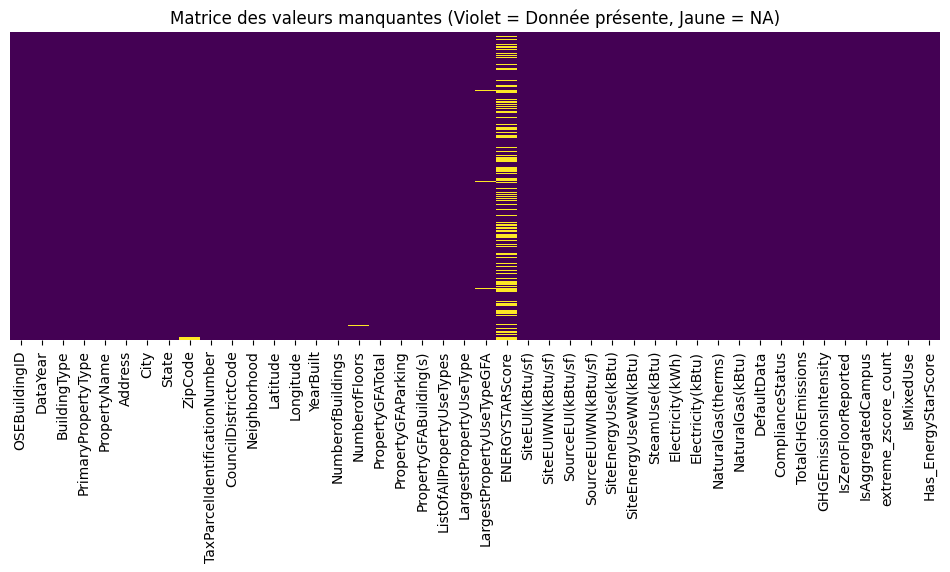

In [5]:
plt.figure(figsize=(12, 4))
sns.heatmap(df_cleaned.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Matrice des valeurs manquantes (Violet = Donnée présente, Jaune = NA)")
plt.show()

# Section 2 : Split train-test

In [6]:
df_cleaned["PrimaryPropertyType"].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'K-12 School', 'Large Office', 'Medical Office', 'Retail Store',
       'Hospital', 'Warehouse', 'Distribution Center', 'Worship Facility',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant'], dtype=object)

In [7]:
# Détection rapide des valeurs manquantes
TARGET = "TotalGHGEmissions"

print("NaN dans Target:", df_cleaned[TARGET].isna().sum())
print("Pourcentage:", df_cleaned[TARGET].isna().mean() * 100)

# NaN par type de bâtiment
print("\nNaN par PrimaryPropertyType:")
print(df_cleaned.groupby('PrimaryPropertyType')[TARGET].apply(lambda x: x.isna().sum()))

NaN dans Target: 0
Pourcentage: 0.0

NaN par PrimaryPropertyType:
PrimaryPropertyType
Distribution Center            0
Hospital                       0
Hotel                          0
K-12 School                    0
Laboratory                     0
Large Office                   0
Medical Office                 0
Mixed Use Property             0
Other                          0
Refrigerated Warehouse         0
Restaurant                     0
Retail Store                   0
Self-Storage Facility          0
Small- and Mid-Sized Office    0
Supermarket / Grocery Store    0
University                     0
Warehouse                      0
Worship Facility               0
Name: TotalGHGEmissions, dtype: int64


## Split avant feature engineering

In [8]:
TARGET = "TotalGHGEmissions"
X = df_cleaned.drop(columns=[TARGET])
y = df_cleaned[TARGET]

# Le split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=df_cleaned['PrimaryPropertyType']
)


## Feature Engineering sur les ensembles séparés

In [9]:

# En cas d'éventuel calcul groupé lors du feature enginenning

logger.info(" Feature Engineering sur TRAIN ")
X_train.name = "X_train"
X_test.name = "X_test"
# Ces transformations doivent être conçues pour n'utiliser que les données de X_train en cas d'utilisation de stats globale
df_train_fe = run_feature_engineering_pipeline(X_train, cfg_ml)
y_train = y_train.loc[df_train_fe.index]  # Réaligner les cibles 

logger.info(" Feature Engineering sur TEST ")
# Appliquez les MÊMES transformations au test, sans ré-apprendre de paramètres.
df_test_fe = run_feature_engineering_pipeline(X_test, cfg_ml)
y_test = y_test.loc[df_test_fe.index]

#  Préparation  pour le pipeline ML
X_train_clean = df_train_fe.copy()
X_test_clean = df_test_fe.copy()


2026-01-11 16:35:04,231 -  Feature Engineering sur TRAIN 
2026-01-11 16:35:04,235 - --- Démarrage : Feature Engineering ---
2026-01-11 16:35:04,332 - ✓ Feature Engineering terminé. Shape: (1136, 43)
2026-01-11 16:35:04,333 -  Feature Engineering sur TEST 
2026-01-11 16:35:04,334 - --- Démarrage : Feature Engineering ---
2026-01-11 16:35:04,431 - ✓ Feature Engineering terminé. Shape: (285, 43)


✓ Feature engineering sauvegardé dans : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\processed\X_train.csv
✓ Feature engineering sauvegardé dans : C:\Users\HP\Desktop\temp\TODO\SEMESTRE_1\ML1\ML-prediction-CO2\data\processed\X_test.csv


# Section 3 : Modéle baseline

In [10]:
print(X_train_clean.columns.tolist())

['BuildingType', 'PrimaryPropertyType', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'DefaultData', 'ComplianceStatus', 'IsZeroFloorReported', 'IsAggregatedCampus', 'extreme_zscore_count', 'IsMixedUse', 'Has_EnergyStarScore', 'log_GFA', 'surface_per_building', 'surface_per_floor', 'Has_Parking', 'Parking_share', 'Age', 'Era', 'Has_ENERGYSTAR', 'Has_Gas', 'Has_Steam', 'TotalEnergy_kBtu_proxy', 'Fossil_kBtu', 'Fossil_Ratio', 'Electrification_Rate', 'Energy_Intensity_kBtu_per_sqft', 'Fossil_Intensity_kBtu_per_sqft', 'Electricity_Intensity_kBtu_per_sqft', 'Gas_Intensity_kBtu_per

In [11]:
# clé de regroupement
GROUP_COL = "PrimaryPropertyType"

if GROUP_COL not in X_train_clean.columns:
    raise ValueError(f"{GROUP_COL} absent de X_train_clean")
if X_train_clean[GROUP_COL].isna().any():
    raise ValueError(f"{GROUP_COL} contient des NaN dans X_train_clean — nettoie avant.")

# déterminer dynamiquement les colonnes (exclure GROUP_COL des listes finales)
num_cols = X_train_clean.select_dtypes(include="number").columns.tolist()
cat_cols = X_train_clean.select_dtypes(include="object").columns.tolist()
if GROUP_COL in num_cols: num_cols.remove(GROUP_COL)
if GROUP_COL in cat_cols: cat_cols.remove(GROUP_COL)

# pour GroupModeImputer on peut laisser None pour inférer dans fit()
# mais ici on fixe explicitement les colonnes catégorielles (sans GROUP_COL)
categorical_features = cat_cols.copy()

class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col: str, min_group_size: int = 1):
        # stocker rigoureusement les paramètres exactement comme reçus
        self.group_col = group_col
        self.min_group_size = min_group_size

    def fit(self, X: pd.DataFrame, y=None):
        # X est attendu comme DataFrame contenant self.group_col + colonnes numériques ciblées
        if self.group_col not in X.columns:
            raise ValueError(f"{self.group_col} absent dans X lors de fit()")
        # compter et calculer médianes par groupe
        group_counts = X.groupby(self.group_col).size()
        medians = X.groupby(self.group_col).median(numeric_only=True)
        # fallback pour petits groupes (mettre NaN pour forcer repli global)
        for g, cnt in group_counts.items():
            if cnt < self.min_group_size and g in medians.index:
                medians.loc[g, :] = np.nan
        self.group_medians_ = medians
        self.global_median_ = X.median(numeric_only=True)
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        # imputer chaque colonne numérique calculée au fit()
        for col in self.group_medians_.columns:
            if col not in X.columns:
                # si la colonne attendue n'est pas présente, skip (robustesse)
                continue
            X[col] = X[col].fillna(X[self.group_col].map(self.group_medians_[col]))
            X[col] = X[col].fillna(self.global_median_[col])
        # retirer la colonne de regroupement avant le scaler
        return X.drop(columns=[self.group_col], errors="ignore")


class GroupModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_col: str, categorical_cols=None, min_group_size: int = 1):
        # ne pas transformer categorical_cols ici 
        self.group_col = group_col
        self.categorical_cols = categorical_cols  # peut être None ; on infère dans fit()
        self.min_group_size = min_group_size

    def fit(self, X: pd.DataFrame, y=None):
        if self.group_col not in X.columns:
            raise ValueError(f"{self.group_col} absent dans X lors de fit()")
        # si categorical_cols None, inférer toutes les colonnes non-group de type object/category
        if self.categorical_cols is None:
            inferred = X.select_dtypes(include=["object", "category"]).columns.tolist()
            self.categorical_cols = [c for c in inferred if c != self.group_col]
        # calculer mode par groupe
        group_counts = X.groupby(self.group_col).size()
        self.group_modes_ = {}
        for col in self.categorical_cols:
            modes = X.groupby(self.group_col)[col].agg(
                lambda s: s.mode().iloc[0] if not s.mode().empty else None
            )
            for g, cnt in group_counts.items():
                if cnt < self.min_group_size and g in modes.index:
                    modes.loc[g] = None
            self.group_modes_[col] = modes
        # global modes fallback
        self.global_modes_ = {col: X[col].mode().iloc[0] for col in self.categorical_cols}
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        for col in self.categorical_cols:
            if col not in X.columns:
                continue
            X[col] = X[col].fillna(X[self.group_col].map(self.group_modes_.get(col, pd.Series())))
            X[col] = X[col].fillna(self.global_modes_.get(col))
        # retirer la colonne de regroupement avant l'encodeur
        return X.drop(columns=[self.group_col], errors="ignore")



In [12]:

# construire pipelines
numeric_pipeline = Pipeline([
    ("imputer", GroupMedianImputer(group_col=GROUP_COL, min_group_size=1)),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", GroupModeImputer(group_col=GROUP_COL, categorical_cols=categorical_features, min_group_size=1)),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# ColumnTransformer : on transmet [GROUP_COL] + cols à chaque sous-pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, [GROUP_COL] + num_cols),
        ("cat", categorical_pipeline, [GROUP_COL] + cat_cols),
    ],
    remainder="drop"
)



In [13]:

# pipeline complet
model = RandomForestRegressor(n_estimators=200, random_state=72, n_jobs=-1)
ml_pipeline = Pipeline([
    ("preproc", preprocessor),
    ("model", model)
])

# fit / predict
ml_pipeline.fit(X_train_clean, y_train)
y_pred = ml_pipeline.predict(X_test_clean)



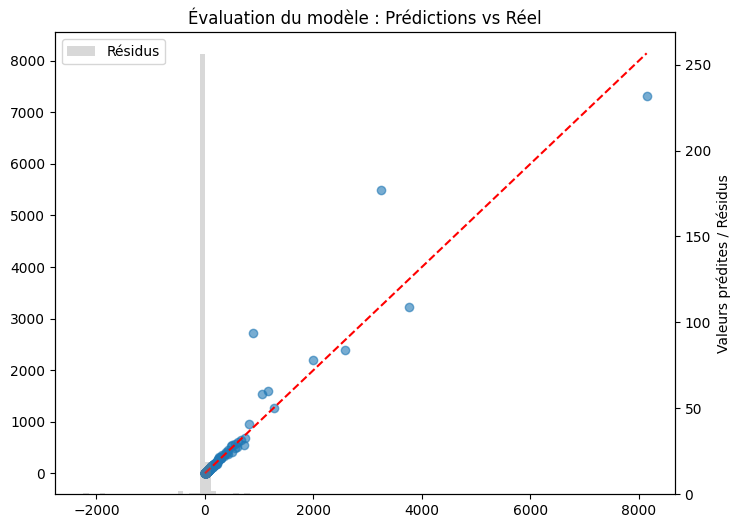

In [14]:
import matplotlib.pyplot as plt
import numpy as np

y_pred = ml_pipeline.predict(X_test_clean)

# Calcul des résidus
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))

# Nuage y_test vs y_pred
plt.scatter(y_test, y_pred, alpha=0.6, label="Prédictions")

# Ligne parfaite
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="y = y_pred")

# Histogramme des résidus sur l’axe secondaire
plt.twinx()
plt.hist(residuals, bins=30, color='gray', alpha=0.3, label="Résidus")

plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites / Résidus")
plt.title("Évaluation du modèle : Prédictions vs Réel")
plt.legend(loc='upper left')
plt.show()


In [15]:
print(X_train_clean.shape, X_test_clean.shape)
print(y_train.shape, y_test.shape)
print(np.intersect1d(X_train_clean.index, X_test_clean.index))


(1136, 61) (285, 61)
(1136,) (285,)
[]


In [18]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score,
    max_error,
    median_absolute_error
)
import numpy as np

# Prédictions
y_pred = ml_pipeline.predict(X_test_clean)

# 1. Erreurs classiques
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
maxe = max_error(y_test, y_pred)

# 2. Scores de variance
r2 = r2_score(y_test, y_pred)
expl_var = explained_variance_score(y_test, y_pred)

# 3. Affichage synthétique
metrics = {
    "MAE": mae,
    "MSE": mse,
    "MedAE": medae,
    "Max Error": maxe,
    "R2": r2,
    "Explained Variance": expl_var
}

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


MAE: 29.8315
MSE: 35228.3871
MedAE: 0.9835
Max Error: 2247.7216
R2: 0.9046
Explained Variance: 0.9050
